In [9]:
from IPython.display import SVG
import numpy as np
from scipy.stats import norm
import time
import pandas as pd 
from sklearn.neighbors.kde import KernelDensity
import matplotlib.pyplot as plt
import pandas as pd
import csv
from synbioTools import tensorChem
from keras import models
from keras import optimizers
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from Bio import SeqIO
from Bio.PDB.Polypeptide import d1_to_index
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_classification

In [31]:
""" Read csv file and return it as a panda dataframe(dictionary) by biopython """
def readfasta(ffile):
    """ Read fasta file, return dictionary """
    record_iterator = SeqIO.parse(ffile, "fasta")
    a=pd.DataFrame(columns=['id','seq'])
    for i in record_iterator:
        a.loc[a.shape[0]+1] = [i.id,str(i.seq[:])]
#     record_dict = SeqIO.to_dict(SeqIO.parse(ffile, "fasta"))
    #df1=pd.DataFrame(record_dict)   
    return a

In [202]:
"""Load Data as pandas dataframe"""
nondata = readfasta("C:/Users/DR/Desktop/P2/Latent-master/data/thermostability/non-thermophilic_proteins.txt")
data = readfasta("C:/Users/DR/Desktop/P2/Latent-master/data/thermostability/thermophilic_proteins.txt")
data['Thermostability']='1'
nondata['Thermostability']='0'

In [295]:
"""Data preprocessing"""
# Append the thermophilic to the non-thermophilic
data=pd.concat([data,nondata])
data=data.sample(frac=1)
# Init input and Y
X=data['seq']
Y=data['Thermostability']

TypeError: cannot concatenate object of type "<class 'numpy.ndarray'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

The mean of the seq length is: 330.63524590163934
The S.D. of the seqs length is: 253.89479962847057


C:\Users\DR\Anaconda3\envs\my-rdkit-env\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


'In statistics, kernel density estimation (KDE) is a non-parametric way to estimate the probability density function \nof a random variable. Kernel density estimation is a fundamental data smoothing problem where inferences about the population\nare made, based on a finite data sample.'

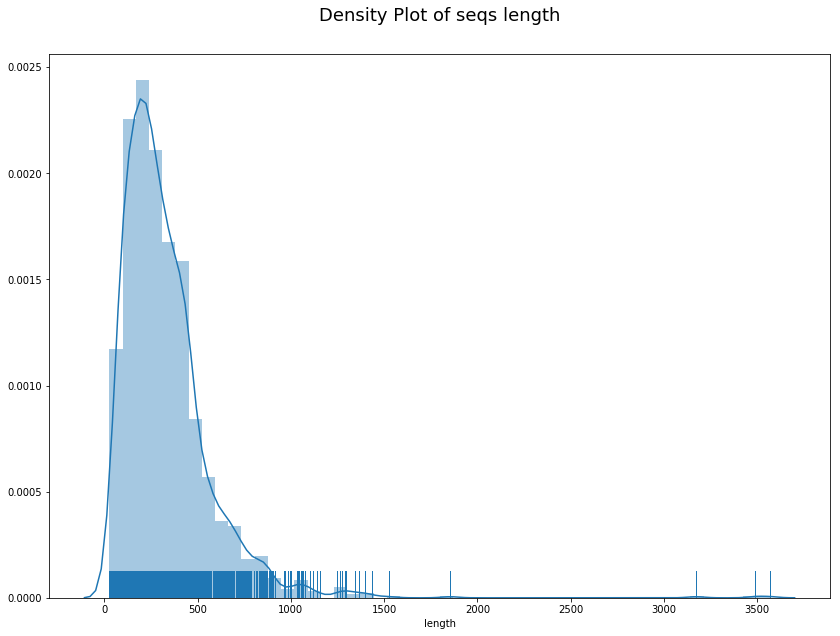

In [139]:
""" Visualize seq length """
# plot the histogram of solubility
import seaborn as sns
length=[]
for i in X:
    length.append(len(i))
train_y_plot = pd.Series( np.squeeze(length), name="length")
mean = train_y_plot.mean()
std = train_y_plot.std()
print("The mean of the seq length is: " + str(mean))
print("The S.D. of the seqs length is: " + str(std))
f,ax= plt.subplots(figsize = (14, 10))
sns.distplot(train_y_plot, kde=True, rug=True, hist=True)
ax.set_title("Density Plot of seqs length", fontsize=18, position=(0.5,1.05))
plt.savefig('Density Plot of seqs length.svg', bbox_inches='tight')

"""In statistics, kernel density estimation (KDE) is a non-parametric way to estimate the probability density function 
of a random variable. Kernel density estimation is a fundamental data smoothing problem where inferences about the population
are made, based on a finite data sample."""

The frequency is: Counter({'L': 53531, 'A': 50534, 'G': 43643, 'V': 43613, 'E': 43415, 'I': 35336, 'K': 34816, 'R': 32726, 'D': 31297, 'S': 29990, 'T': 27349, 'P': 25605, 'F': 21545, 'N': 21151, 'Y': 18448, 'Q': 16743, 'M': 12832, 'H': 10729, 'W': 6661, 'C': 4756, '@': 2, 'X': 2, 'U': 1})
Amino acids type is: 23
They are: dict_keys(['M', 'T', 'K', 'S', 'I', 'Y', 'F', 'L', 'G', 'H', 'N', 'Q', 'P', 'V', 'D', 'E', 'R', 'A', 'W', 'C', '@', 'X', 'U'])


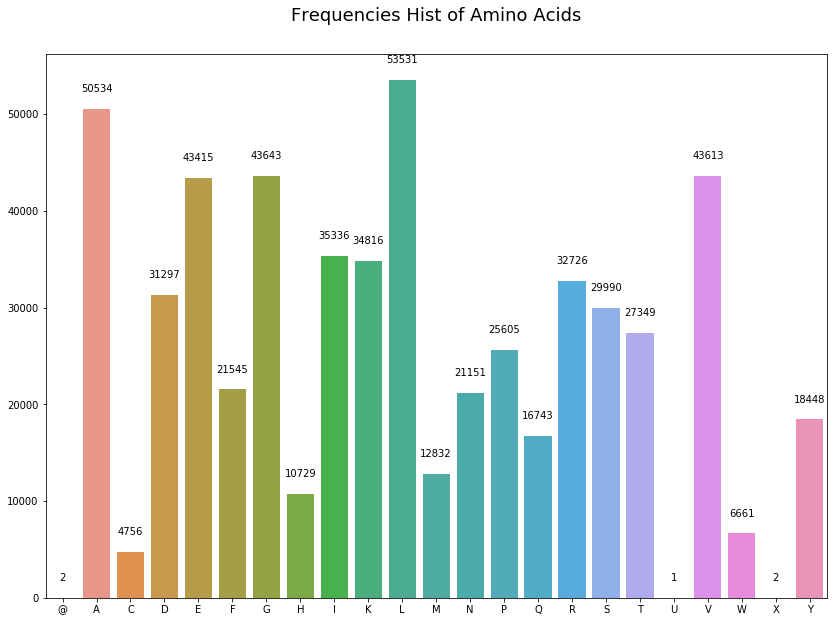

In [159]:
from collections import Counter

# Count amino acid
tmp=""
for i in X:
    tmp = tmp + str(i)
c2 = Counter(tmp)
print("The frequency is: " + str(c2))
print("Amino acids type is: " + str(len(c2)))
print("They are: " + str(c2.keys()))
k = pd.DataFrame.from_dict([c2])

f,ax= plt.subplots(figsize = (14, 10))
g=sns.barplot(data=k,ax=ax)
for p in g.patches:
        g.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', rotation=0, xytext=(0, 20), textcoords='offset points')
ax.set_title("Frequencies Hist of Amino Acids", fontsize=18, position=(0.5,1.05))
plt.savefig('Frequencies Hist of Amino Acids.svg', bbox_inches='tight')

In [275]:



d1_to_index =['M', 'T', 'K', 'S', 'I', 'Y', 'F', 'L', 'G', 'H', 'N', 'Q', 'P', 'V', 'D', 'E', 'R', 'A', 'W', 'C', '@', 'X', 'U']

# def _onehotencode(s, vocab=d1_to_index):
#     """ Function to one-hot encode a sring.
#     :param s: {str} String to encode in one-hot fashion
#     :param vocab: vocabulary to use fore encoding, if None, default AAs are used
#     :return: one-hot encoded string as a np.array
#     """
#     if not vocab:
#         vocab = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W',
#                  'Y', ' ']
    
#     # generate translation dictionary for one-hot encoding
#     to_one_hot = dict()
#     for i, a in enumerate(vocab):
#         v = np.zeros(len(vocab))
#         v[i] = 1
#         to_one_hot[a] = v
    
#     result = []
#     for l in s:
#         result.append(to_one_hot[l])
#     result = np.array(result)
#     return np.reshape(result, (1, result.shape[0], result.shape[1])), to_one_hot, vocab

def one_hot(seq):
    """ Convert amino acid to one-hot vector stack """
    # Generate amino acids one-hot dict
    to_one_hot = dict()
    for i, a in enumerate(d1_to_index):
        v = np.zeros(len(d1_to_index))
        v[i] = 1
        to_one_hot[a] = v
    ix = []
    result = []
    # Tranfer the seq by the dict
    for m in seq:
        result.append(to_one_hot[m])
    result = np.array(result)
    return np.reshape(result, (1, result.shape[0], result.shape[1]))

def index_seq(seq):
    """ Convert amino acid to numerical index """
    index=[]
    for i in seq:
        p=d1_to_index.index(i)
        index.append(p)
    index = index
    return index

def tensor_pad(seqs):
    # Init seqs vector
    seqs_index=[]
    # Transfer seqs into index vector
    for seq in seqs:
        seqs_index.append(index_seq(seq))
    # Pad the seqs
    pad=pad_sequences(seqs_index, maxlen=None, dtype='int32',padding='pre', truncating='pre', value=0.)
    # one-hot encode the pad
    encoded = to_categorical(pad)
    return encoded
    #return seqs_index


In [289]:
seqs_index=[]
for seq in list(X):
    seqs_index.append(index_seq(seq))
data=pad_sequences(seqs_index, maxlen=None, dtype='int32',padding='pre', truncating='pre', value=0.)

In [290]:
# Samples, seq_length and one-hot length
print(data.shape[:])

(1708, 3567)


In [234]:
def one_hot_encode(seqs,window,step, target='all'):
        """ Chop up loaded sequences into patterns of length ``window`` by moving by stepsize ``step`` and translate
        them with a one-hot vector encoding
        :param target: {str} whether all proceeding AA should be learned or just the last one in sequence (`all`, `one`)
        :return: one-hot encoded sequence patterns in self.X and corresponding target amino acids in self.y
        """
        X=[]
        if self.window == 0:
            for seq in seqs:
                X.append([one_hot[char] for char in seq[:-step]])
#                 if target == 'all':
#                     y.append([one_hot[char] for char in seq[self.step:]])
#                 elif target == 'one':
#                     y.append(seq[-step:])
            
            X = np.reshape(X, (len(X), len(self.sequences[0]) - step, len(d1_to_index)))
#            self.y = np.reshape(self.y, (len(self.y), len(self.sequences[0]) - self.step, len(self.vocab)))
        
        else:
            for s in self.sequences:
                for i in range(0, len(s) - self.window, self.step):
                    self.X.append([self.to_one_hot[char] for char in s[i: i + self.window]])
                    if target == 'all':
                        self.y.append([self.to_one_hot[char] for char in s[i + 1: i + self.window + 1]])
                    elif target == 'one':
                        self.y.append(s[-self.step:])
            
            self.X = np.reshape(self.X, (len(self.X), self.window, len(self.vocab)))
            self.y = np.reshape(self.y, (len(self.y), self.window, len(self.vocab)))
        
        print("\nData shape:\nX: " + str(self.X.shape) + "\ny: " + str(self.y.shape))

def tensorSeq(seqs, MAX_SEQ_LENGTH, SEQDEPTH, TOKEN_SIZE=20):
    """ Encode an amino acid sequence as a tensor 
    by concatenating one-hot encoding up to desired depth """
    TRAIN_BATCH_SIZE = len(seqs)
    Xs = np.zeros( (TRAIN_BATCH_SIZE, MAX_SEQ_LENGTH, SEQDEPTH*TOKEN_SIZE) )
    for i in range(0, len(seqs)):
        seq_one_hot = one_hot( seqs[i] )
        for l in range(0, MAX_SEQ_LENGTH):
            for k in range(0, SEQDEPTH):
                try:
                    Xs[i, l, seq_one_hot[l+k] + TOKEN_SIZE*k] = 1
                except:
                    continue
    """ Flip sequences (zero-padding at the start) """
    Xsr = np.flip( Xs, 1 )
    return Xsr, Xs

In [374]:
"""Hold-out method"""
# Split the data in train/test = 0.9/0.1
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.10)
y_test=[int(k) for k in y_test]
y_train=[int(k) for k in y_train]
# y_train=np.array([ int(i) for i in np.array(y_train)]).reshape(1537,1)
# y_test=np.array([ int(i) for i in np.array(y_test)]).reshape(171,1)
X_train=X_train.reshape(1537,1, 3567)
X_test=X_test.reshape(1537,1, 3567)
print("X_train: "+str(X_train.shape[:]))
print("X_test: "+str(X_test.shape[:]))
# print("y_train: "+str(y_train.shape[:]))
# print("y_test: "+str(y_test.shape[:]))

ValueError: cannot reshape array of size 609957 into shape (1537,1,3567)

In [344]:
from keras.layers import Dense, Flatten, Input
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
# define documents
docs = ['Well done!',
        'Good work',
        'Great effort',
        'nice work',
        'Excellent!',
        'Weak',
        'Poor effort!',
        'not good',
        'poor work',
        'Could have done better.']
# define class labels
labels = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
# integer encode the documents
vocab_size = 50
encoded_docs = [one_hot(d, vocab_size) for d in docs]
print(encoded_docs)
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)
# define the model
input = Input(shape=(4, ))
x = Embedding(vocab_size, 8, input_length=max_length)(input)
x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=input, outputs=x)
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())
# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy * 100))

[[10, 36], [7, 45], [24, 3], [28, 45], [4], [20], [48, 3], [49, 7], [48, 45], [4, 13, 36, 18]]
[[10 36  0  0]
 [ 7 45  0  0]
 [24  3  0  0]
 [28 45  0  0]
 [ 4  0  0  0]
 [20  0  0  0]
 [48  3  0  0]
 [49  7  0  0]
 [48 45  0  0]
 [ 4 13 36 18]]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 4, 8)              400       
_________________________________________________________________
flatten_3 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________
None
Accuracy: 89.999998


In [373]:
# data_dim = len(word_index) + 1
# timesteps = 8
# num_classes = 1

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(Embedding(output_dim=2, input_dim=23, input_length=3567))
# model.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
# model.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
# model.add(LSTM(32))  # return a single vector of dimension 32
model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy']) # Require label as one-hot encoded

model.fit(X_train, y_train,batch_size=5, epochs=5, validation_data=(X_test,  y_test))

ValueError: Input 0 is incompatible with layer flatten_5: expected min_ndim=3, found ndim=2